In [2]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [3]:
# Cargamos el CSV que generó tu script de ingesta
df = pd.read_csv('../data/raw_btc_data.csv', index_col=0, parse_dates=True)

# Limpieza rápida: eliminamos niveles de columnas si Yahoo Finance trajo multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"Dataset cargado con {len(df)} registros.")
df.head()

Dataset cargado con 7769 registros.


C:\Users\fdutr\AppData\Local\Temp\ipykernel_28896\3503370790.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('../data/raw_btc_data.csv', index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume
Price,,,,,
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,NaN,NaN,NaN,NaN,NaN
2025-12-31 00:00:00+00:00,88407.7265625,88407.7265625,88407.7265625,88407.7265625,0
2025-12-31 00:01:00+00:00,88375.3125,88375.3125,88375.3125,88375.3125,0
2025-12-31 00:02:00+00:00,88342.1953125,88342.1953125,88342.1953125,88342.1953125,4481024


In [4]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(
    title='Precio de Bitcoin (Últimos 7 días)',
    yaxis_title='Precio USD',
    xaxis_title='Fecha/Hora',
    template='plotly_dark'
)

fig.show()

In [6]:
# Convertir la columna 'Close' a tipo numérico
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Código para añadir la línea al gráfico existente
df['MA_20'] = df['Close'].rolling(window=20).mean()

fig.add_trace(go.Scatter(x=df.index, 
                         y=df['MA_20'], 
                         mode='lines', 
                         name='Media Móvil 20',
                         line=dict(color='yellow', width=2)))

In [7]:
# Crear columnas con el precio de hace 1, 2 y 3 periodos (Lags)
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)

# Crear el "Target": ¿El precio de la próxima vela será mayor al actual? (1 = Sube, 0 = Baja)
# Esto convierte nuestro problema en uno de CLASIFICACIÓN
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Limpiar los NaN que se crean al desplazar los datos
df_ml = df.dropna()

print(df_ml[['Close', 'Close_Lag1', 'Target']].head())

                                  Close    Close_Lag1  Target
Price                                                        
2025-12-31 00:19:00+00:00  88217.968750  88285.273438       0
2025-12-31 00:20:00+00:00  88213.976562  88217.968750       1
2025-12-31 00:21:00+00:00  88251.398438  88213.976562       0
2025-12-31 00:23:00+00:00  88225.398438  88251.398438       1
2025-12-31 00:24:00+00:00  88243.679688  88225.398438       0


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# 1. Definimos nuestras variables de entrada (X) y lo que queremos predecir (y)
features = ['Close', 'MA_20', 'Close_Lag1', 'Close_Lag2']
X = df_ml[features]
y = df_ml['Target']

# 2. Split de datos: 80% para entrenar, 20% para testear
# Importante: En series de tiempo NO se debe mezclar (shuffle=False) para no usar el futuro para predecir el pasado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Creamos y entrenamos el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predicciones
y_pred = model.predict(X_test)

# 5. Evaluación
print(f"Precisión General (Accuracy): {accuracy_score(y_test, y_pred):.2f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Precisión General (Accuracy): 0.52

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.86      0.65       806
           1       0.50      0.15      0.23       744

    accuracy                           0.52      1550
   macro avg       0.51      0.51      0.44      1550
weighted avg       0.51      0.52      0.45      1550



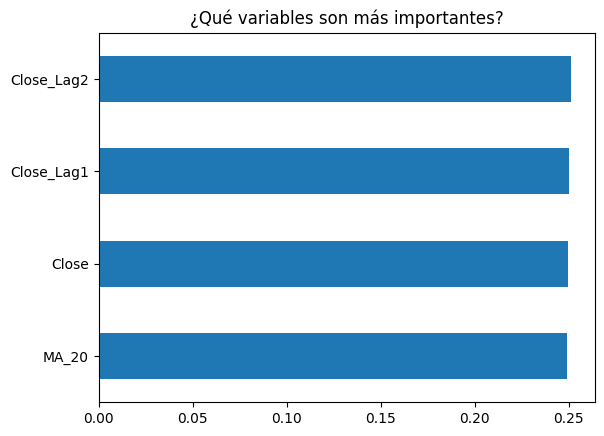

In [10]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='¿Qué variables son más importantes?')
plt.show()

In [ ]:
import joblib

# Guardamos el modelo y la lista de features para que la App sepa qué columnas usar
model_data = {
    'model': model,
    'features': features
}
joblib.dump(model_data, '..\models\crypto_model.pkl')
print("Modelo guardado con éxito en models\crypto_model.pkl.")

models\crypto_model.pkl guardado con éxito.
